In [6]:
# Imports
import os
import sys
import pickle
import random
from typing import List, Dict, Callable
from collections import defaultdict, Counter

import csv
import gzip
import h5py
import shutil
import zipfile
import pydicom
import numpy as np

from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

from ml4cvd.defines import StorageType
from ml4cvd.arguments import parse_args, TMAPS, _get_tmap
from ml4cvd.TensorMap import TensorMap, Interpretation
from ml4cvd.tensor_generators import test_train_valid_tensor_generators
from ml4cvd.models import train_model_from_generators, make_multimodal_multitask_model, _inspect_model
from ml4cvd.recipes import test_multimodal_multitask, train_multimodal_multitask, saliency_maps

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
# Paths
HD5_FOLDER = './mnist_hd5s/'
OUTPUT_FOLDER = './runs/'

In [3]:
def load_data(dataset):
    ''' Loads the dataset
    :param dataset: the path to the dataset (here MNIST)'''
    data_dir, data_file = os.path.split(dataset)
    if data_dir == "" and not os.path.isfile(dataset):
        # Check if dataset is in the data directory.
        new_path = os.path.join("data", dataset)
        if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
            dataset = new_path

    if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
        from urllib.request import urlretrieve
        origin = ('http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz')
        print('Downloading data from %s' % origin)
        if not os.path.exists(os.path.dirname(dataset)):
            os.makedirs(os.path.dirname(dataset))	
        urlretrieve(origin, dataset)

    print('loading data...')
    f = gzip.open(dataset, 'rb')
    if sys.version_info[0] == 3:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        train_set, valid_set, test_set = u.load()
    else:
        train_set, valid_set, test_set = pickle.load(f)
    f.close()

    return train_set, valid_set, test_set

In [9]:
def plot_mnist(sides):
    train, _, _ = load_data('mnist.pkl.gz')
    print(train[0].shape)
    mnist_images = train[0].reshape((-1, 28, 28, 1))
    sides = int(np.ceil(np.sqrt(min(sides, mnist_images.shape[0]))))
    _, axes = plt.subplots(sides, sides, figsize=(16, 16))
    for i in range(sides*sides):
        axes[i // sides, i % sides].imshow(mnist_images[i, ..., 0], cmap='gray')
        axes[i // sides, i % sides].set_xticks(())
        axes[i // sides, i % sides].set_yticks(())

loading data...
(50000, 784)


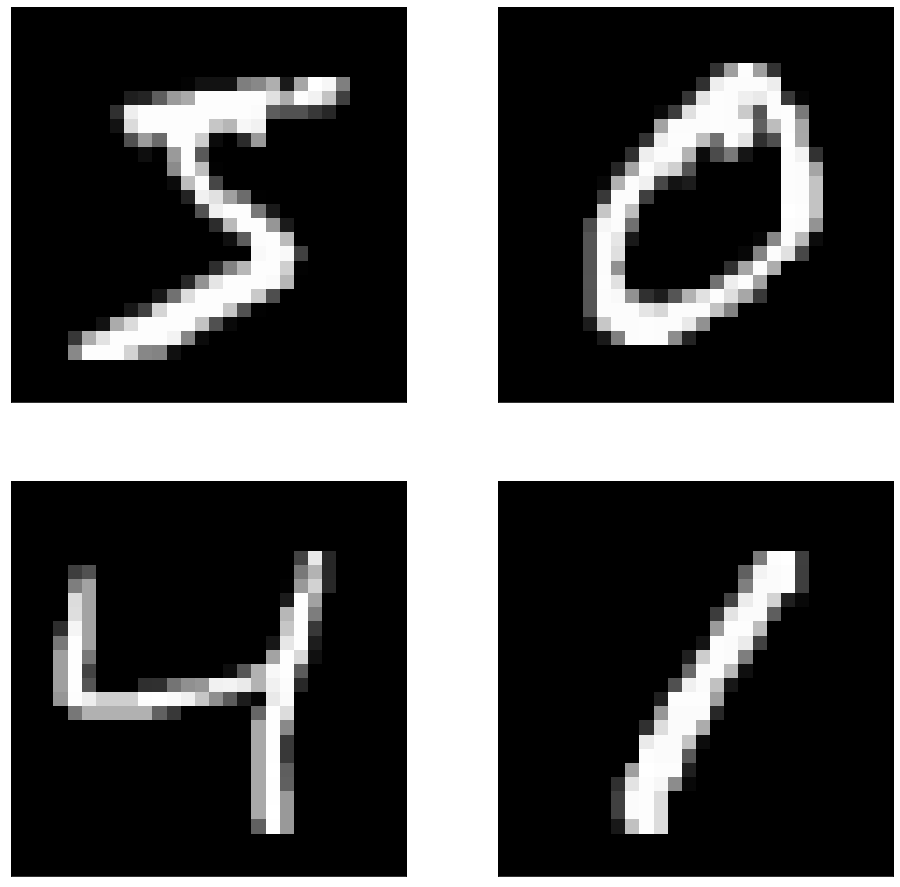

In [10]:
plot_mnist(4)

loading data...
(50000, 784)


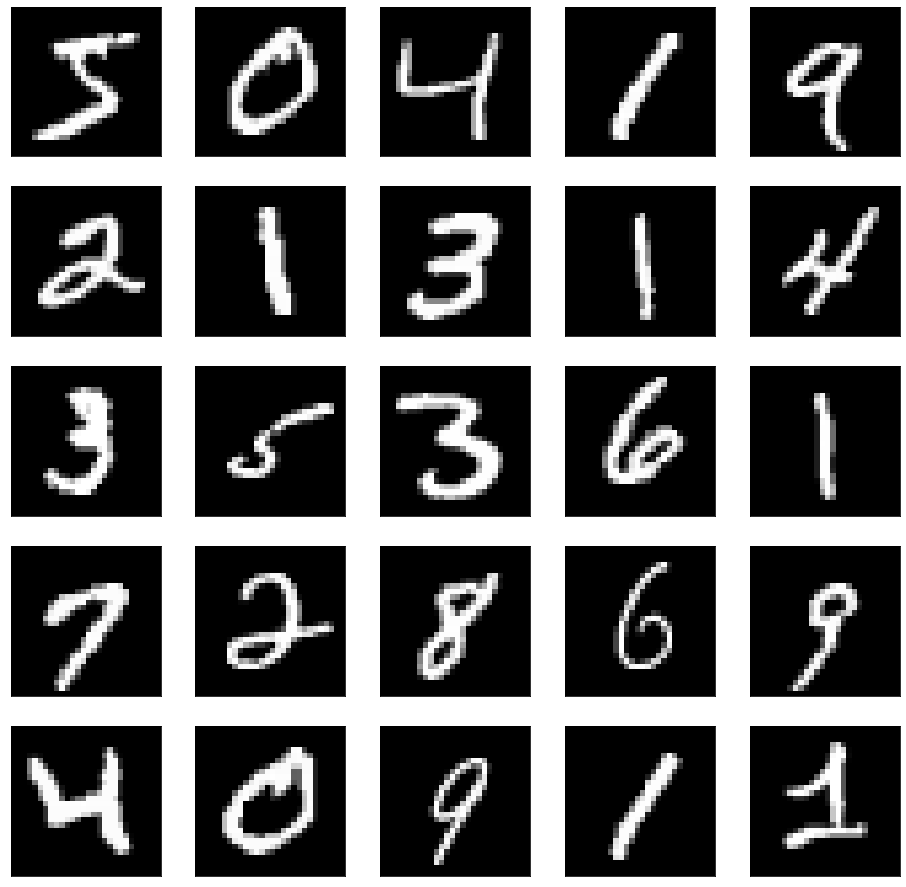

In [19]:
plot_mnist(25)

## Tensorization
It is often helpful to separate data preparation from model training.  In ML4CVD we call the final data preparation process tensorization.  Tensorization involves gathering all input files (XMLS, CSVs, DICOMs, PNGs, etc) and consolidating them into compressed HD5 files.  We tend to make one HD5 file per individual in the cohort we are studying.  The files contain the raw data and labels (inputs and outputs) we will use to train models.

In [17]:
def mnist_as_hd5(hd5_folder):
    train, _, _ = load_data('mnist.pkl.gz')
    mnist_images = train[0].reshape((-1, 28, 28, 1))
    if not os.path.exists(hd5_folder):
        os.makedirs(hd5_folder)
    for i, mnist_image in enumerate(mnist_images):
        with h5py.File(os.path.join(hd5_folder, f'{i}.hd5'), 'w') as hd5:
            hd5.create_dataset('mnist_image', data=mnist_image)
            hd5.create_dataset('mnist_label', data=[train[1][i]])
        if (i+1) % 5000 == 0:
            print(f'Wrote {i+1} MNIST images and labels as HD5 files')

In [18]:
mnist_as_hd5(HD5_FOLDER)

loading data...
Wrote 4999 MNIST images and labels as HD5 files
Wrote 9999 MNIST images and labels as HD5 files
Wrote 14999 MNIST images and labels as HD5 files
Wrote 19999 MNIST images and labels as HD5 files
Wrote 24999 MNIST images and labels as HD5 files
Wrote 29999 MNIST images and labels as HD5 files
Wrote 34999 MNIST images and labels as HD5 files
Wrote 39999 MNIST images and labels as HD5 files
Wrote 44999 MNIST images and labels as HD5 files
Wrote 49999 MNIST images and labels as HD5 files


## TensorMaps
The central data structure in the ML4CVD codebase is the TensorMap.
This abstraction provides a way to translate ***any*** kind of input data, into structured numeric tensors with clear semantics for interpretation and modeling.  TensorMaps guarantee a shape, a way to construct tensors of that shape from the HD5 files created during tensorization and a meaning to the values in the tensor that the TensorMap yields.  The most important method of each TensorMap is their ***tensor_from_file*** function.  This callback function takes the TensorMap, an HD5 file handle, and an optional dictionary as input arguments and it returns a numpy array.

In [4]:
def mnist_image_from_hd5(tm, hd5, dependents={}):
     return np.array(hd5['mnist_image'])

def mnist_label_from_hd5(tm, hd5, dependents={}):
    one_hot = np.zeros(tm.shape, dtype=np.float32)
    one_hot[int(hd5['mnist_label'][0])] = 1.0
    return one_hot
    
TMAPS['mnist_image'] = TensorMap('mnist_image', shape=(28, 28, 1), tensor_from_file=mnist_image_from_hd5)
TMAPS['mnist_label'] = TensorMap('mnist_label', Interpretation.CATEGORICAL, tensor_from_file=mnist_label_from_hd5,
                                 channel_map={f'digit_{i}': i for i in range(10)})


## Command Line Friendly Jupyter Notebooks
By directly setting the `sys.argv` array in our jupyter notebooks we make the process of translating from notebook to command line straightforward.  For example, the cell below can be replicated on the command line by running:
```
./scripts/tf.sh $HOME/ml/ml4cvd/recipes.py --mode train --tensors ./mnist_hd5s/ \
    --input_tensors mnist_image --output_tensors mnist_label \
    --batch_size 64 --test_steps 64 --epochs 24 \
    --output_folder ./runs/ --id learn_mnist
```
The script `tf.sh` starts the appropriate docker container and then calls python on the provided arguments.


In [6]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'mnist_image',
            '--output_tensors', 'mnist_label',
            '--batch_size', '64',
            '--test_steps', '64',
            '--epochs', '24',
            '--output_folder', OUTPUT_FOLDER,
            '--id', 'learn_mnist'
           ]
args = parse_args()
train_multimodal_multitask(args)

2020-05-22 17:00:11,151 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./runs/learn_mnist/log_2020-05-22_17-00_0.log.
2020-05-22 17:00:11,152 - arguments:372 - INFO - Command Line was: 
./scripts/tf.sh train --tensors ./mnist_hd5s/ --input_tensors mnist_image --output_tensors mnist_label --batch_size 64 --test_steps 64 --epochs 24 --output_folder ./runs/ --id learn_mnist

2020-05-22 17:00:11,154 - arguments:373 - INFO - Total TensorMaps: 558 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=2.0, anneal_rate=0.0, anneal_shift=0.0, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=64, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, bottleneck_type=<BottleneckType.FlattenRestructure: 1>, cache_size=875000000.0, categorical_field_ids=[], continuous_field_ids=[], continuous_file=None, continuo

2020-05-22 17:00:15,540 - tensor_generators:149 - INFO - Started 3 train workers with cache size 0.875GB.
2020-05-22 17:00:15,915 - tensor_generators:149 - INFO - Started 1 validation workers with cache size 0.875GB.
Train for 72 steps, validate for 18 steps
Epoch 1/24
71/72 [============================>.] - ETA: 0s - loss: 2.2996 - categorical_accuracy: 0.1092 - digit_0_precision: 0.0000e+00 - digit_1_precision: 0.0000e+00 - digit_2_precision: 0.0000e+00 - digit_3_precision: 0.0000e+00 - digit_4_precision: 0.0000e+00 - digit_5_precision: 0.0000e+00 - digit_6_precision: 0.0000e+00 - digit_7_precision: 0.0000e+00 - digit_8_precision: 0.0000e+00 - digit_9_precision: 0.0000e+00 - digit_0_recall: 0.0000e+00 - digit_1_recall: 0.0000e+00 - digit_2_recall: 0.0000e+00 - digit_3_recall: 0.0000e+00 - digit_4_recall: 0.0000e+00 - digit_5_recall: 0.0000e+00 - digit_6_recall: 0.0000e+00 - digit_7_recall: 0.0000e+00 - digit_8_recall: 0.0000e+00 - digit_9_recall: 0.0000e+00
Epoch 00001: val_loss imp

Epoch 5/24
71/72 [============================>.] - ETA: 0s - loss: 0.5614 - categorical_accuracy: 0.8250 - digit_0_precision: 0.9475 - digit_1_precision: 0.9631 - digit_2_precision: 0.9451 - digit_3_precision: 0.9316 - digit_4_precision: 0.8891 - digit_5_precision: 0.8124 - digit_6_precision: 0.9469 - digit_7_precision: 0.8841 - digit_8_precision: 0.8506 - digit_9_precision: 0.7599 - digit_0_recall: 0.8513 - digit_1_recall: 0.9438 - digit_2_recall: 0.8449 - digit_3_recall: 0.7435 - digit_4_recall: 0.5452 - digit_5_recall: 0.5633 - digit_6_recall: 0.8898 - digit_7_recall: 0.7001 - digit_8_recall: 0.6945 - digit_9_recall: 0.6127
Epoch 00005: val_loss improved from 0.70360 to 0.42737, saving model to ./runs/learn_mnist/learn_mnist.h5
72/72 [==============================] - 4s 56ms/step - loss: 0.5590 - categorical_accuracy: 0.8260 - digit_0_precision: 0.9468 - digit_1_precision: 0.9636 - digit_2_precision: 0.9459 - digit_3_precision: 0.9326 - digit_4_precision: 0.8867 - digit_5_precisio

2020-05-22 17:00:55,929 - tensor_generators:200 - INFO - Categorical 
mnist_label has 34927 total examples.
	Label digit_0 3425 examples, 9.81% of total.
	Label digit_1 3958 examples, 11.33% of total.
	Label digit_2 3404 examples, 9.75% of total.
	Label digit_3 3577 examples, 10.24% of total.
	Label digit_4 3403 examples, 9.74% of total.
	Label digit_5 3117 examples, 8.92% of total.
	Label digit_6 3480 examples, 9.96% of total.
	Label digit_7 3664 examples, 10.49% of total.
	Label digit_8 3395 examples, 9.72% of total.
	Label digit_9 3504 examples, 10.03% of total.
71/72 [============================>.] - ETA: 0s - loss: 0.3385 - categorical_accuracy: 0.8963 - digit_0_precision: 0.9702 - digit_1_precision: 0.9576 - digit_2_precision: 0.9349 - digit_3_precision: 0.9277 - digit_4_precision: 0.9187 - digit_5_precision: 0.9146 - digit_6_precision: 0.9480 - digit_7_precision: 0.9451 - digit_8_precision: 0.8937 - digit_9_precision: 0.8863 - digit_0_recall: 0.9558 - digit_1_recall: 0.9551 - d

71/72 [============================>.] - ETA: 0s - loss: 0.2093 - categorical_accuracy: 0.9379 - digit_0_precision: 0.9736 - digit_1_precision: 0.9777 - digit_2_precision: 0.9453 - digit_3_precision: 0.9518 - digit_4_precision: 0.9481 - digit_5_precision: 0.9438 - digit_6_precision: 0.9565 - digit_7_precision: 0.9579 - digit_8_precision: 0.9420 - digit_9_precision: 0.8836 - digit_0_recall: 0.9596 - digit_1_recall: 0.9681 - digit_2_recall: 0.9146 - digit_3_recall: 0.9055 - digit_4_recall: 0.9312 - digit_5_recall: 0.9045 - digit_6_recall: 0.9544 - digit_7_recall: 0.9033 - digit_8_recall: 0.9004 - digit_9_recall: 0.8789
Epoch 00015: val_loss did not improve from 0.15011
72/72 [==============================] - 3s 39ms/step - loss: 0.2104 - categorical_accuracy: 0.9371 - digit_0_precision: 0.9720 - digit_1_precision: 0.9764 - digit_2_precision: 0.9461 - digit_3_precision: 0.9525 - digit_4_precision: 0.9488 - digit_5_precision: 0.9400 - digit_6_precision: 0.9571 - digit_7_precision: 0.9569 

Epoch 19/24
71/72 [============================>.] - ETA: 0s - loss: 0.1576 - categorical_accuracy: 0.9496 - digit_0_precision: 0.9720 - digit_1_precision: 0.9792 - digit_2_precision: 0.9623 - digit_3_precision: 0.9628 - digit_4_precision: 0.9559 - digit_5_precision: 0.9635 - digit_6_precision: 0.9684 - digit_7_precision: 0.9556 - digit_8_precision: 0.9570 - digit_9_precision: 0.9175 - digit_0_recall: 0.9661 - digit_1_recall: 0.9669 - digit_2_recall: 0.9621 - digit_3_recall: 0.9275 - digit_4_recall: 0.9206 - digit_5_recall: 0.9235 - digit_6_recall: 0.9666 - digit_7_recall: 0.9329 - digit_8_recall: 0.9350 - digit_9_recall: 0.9145
Epoch 00019: val_loss did not improve from 0.10986
72/72 [==============================] - 3s 36ms/step - loss: 0.1571 - categorical_accuracy: 0.9497 - digit_0_precision: 0.9724 - digit_1_precision: 0.9794 - digit_2_precision: 0.9605 - digit_3_precision: 0.9610 - digit_4_precision: 0.9565 - digit_5_precision: 0.9640 - digit_6_precision: 0.9674 - digit_7_precis

2020-05-22 17:01:50,043 - plots:1500 - INFO - ROC Label digit_0 area: 1.000 n=381 Truth shape (4096, 10), true sums [381. 478. 441. 415. 394. 383. 389. 416. 407. 392.]
2020-05-22 17:01:50,045 - plots:1500 - INFO - ROC Label digit_1 area: 0.999 n=478 Truth shape (4096, 10), true sums [381. 478. 441. 415. 394. 383. 389. 416. 407. 392.]
2020-05-22 17:01:50,048 - plots:1500 - INFO - ROC Label digit_2 area: 0.998 n=441 Truth shape (4096, 10), true sums [381. 478. 441. 415. 394. 383. 389. 416. 407. 392.]
2020-05-22 17:01:50,052 - plots:1500 - INFO - ROC Label digit_3 area: 0.998 n=415 Truth shape (4096, 10), true sums [381. 478. 441. 415. 394. 383. 389. 416. 407. 392.]
2020-05-22 17:01:50,055 - plots:1500 - INFO - ROC Label digit_4 area: 0.999 n=394 Truth shape (4096, 10), true sums [381. 478. 441. 415. 394. 383. 389. 416. 407. 392.]
2020-05-22 17:01:50,058 - plots:1500 - INFO - ROC Label digit_5 area: 0.999 n=383 Truth shape (4096, 10), true sums [381. 478. 441. 415. 394. 383. 389. 416. 407

{'digit_0': 0.9997965261071841,
 'digit_1': 0.9988117293587849,
 'digit_2': 0.9981170762878795,
 'digit_3': 0.9980099697895085,
 'digit_4': 0.999308920682194,
 'digit_5': 0.9985816540431298,
 'digit_6': 0.999658119183952,
 'digit_7': 0.998583821070234,
 'digit_8': 0.998107795071742,
 'digit_9': 0.9987630581390223}

## Evaluating ML Models in ML4CVD
Each ML4CVD training run creates several plots to give insight into model performance and learning dynamics.  The plots created will depend on the TensorMaps used but in general will include a metric history showing learning curves of each metric tracked during training, performance plots like ROC and Precision Recall curves for classifiers or scatter plots for regressors, calibration plots, and a t-SNE plot showing a 2D representation of the learned embedding of the trained model.
![./runs/learn_mnist/calibrations_mnist_label.png](./runs/learn_mnist/metric_history_learn_mnist.png)
![./runs/learn_mnist/calibrations_mnist_label.png](./runs/learn_mnist/precision_recall_mnist_label.png)
![./runs/learn_mnist/calibrations_mnist_label.png](./runs/learn_mnist/per_class_roc_mnist_label.png)
![./runs/learn_mnist/calibrations_mnist_label.png](./runs/learn_mnist/calibrations_mnist_label.png)
![./runs/learn_mnist/calibrations_mnist_label.png](./runs/learn_mnist/tsne_plot.png)

## Survival Analysis

In [5]:
def mnist_label_as_time_to_event(tm, hd5, dependents={}):
    tensor = np.zeros(tm.shape, dtype=np.float32)
    label = float(hd5['mnist_label'][0])
    tensor[0] = 1.0 if np.random.rand() > (label / 10) else 0.0
    tensor[1] = np.random.randint(1, 3650)
    return tensor
    
TMAPS['mnist_time_to_event'] = TensorMap('mnist_time_to_event', Interpretation.TIME_TO_EVENT, 
                                         tensor_from_file=mnist_label_as_time_to_event)

In [6]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'mnist_image',
            '--output_tensors', 'mnist_time_to_event',
            '--training_steps', '64',
            '--validation_steps', '24',
            '--test_steps', '30',
            '--batch_size', '32',
            '--epochs', '1',
            '--eager',
            '--output_folder', OUTPUT_FOLDER,
            '--id', 'mnist_time_to_event'
           ]
args = parse_args()
train_multimodal_multitask(args)

2020-05-22 19:58:32,299 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./runs/mnist_time_to_event/log_2020-05-22_19-58_0.log.
2020-05-22 19:58:32,301 - arguments:372 - INFO - Command Line was: 
./scripts/tf.sh train --tensors ./mnist_hd5s/ --input_tensors mnist_image --output_tensors mnist_time_to_event --training_steps 64 --validation_steps 24 --test_steps 30 --batch_size 32 --epochs 1 --eager --output_folder ./runs/ --id mnist_time_to_event

2020-05-22 19:58:32,302 - arguments:373 - INFO - Total TensorMaps: 559 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=2.0, anneal_rate=0.0, anneal_shift=0.0, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=32, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, bottleneck_type=<BottleneckType.FlattenRestructure: 1>, cache_size=875000000.0, categori

2020-05-22 19:58:35,954 - tensor_generators:149 - INFO - Started 3 train workers with cache size 0.875GB.
2020-05-22 19:58:36,245 - tensor_generators:149 - INFO - Started 1 validation workers with cache size 0.875GB.
Train for 64 steps, validate for 24 steps
63/64 [============================>.] - ETA: 0s - loss: 1.4123
Epoch 00001: val_loss improved from inf to 1.38372, saving model to ./runs/mnist_time_to_event/mnist_time_to_event.h5
64/64 [==============================] - 14s 218ms/step - loss: 1.4114 - val_loss: 1.3837
2020-05-22 19:58:50,438 - tensor_generators:226 - INFO - Stopped 4 workers.
2020-05-22 19:58:50,444 - tensor_generators:226 - INFO - Stopped 2 workers.
2020-05-22 19:58:50,445 - models:1092 - INFO - Model weights saved at: ./runs/mnist_time_to_event/mnist_time_to_event.h5
2020-05-22 19:58:51,356 - plots:203 - INFO - Saved learning curves at:./runs/mnist_time_to_event/metric_history_mnist_time_to_event.png
2020-05-22 19:58:51,530 - tensor_generators:149 - INFO - Sta

{'mnist_time_to_event_C_Index_0.56_vs_ROC': 0.6698211718855814}

![./runs/mnist_time_to_event/survivorship_fu_1825_mnist_time_to_event.png](./runs/mnist_time_to_event/survivorship_fu_1825_mnist_time_to_event.png)

In [ ]:
def mnist_invert_label_as_time_to_event(tm, hd5, dependents={}):
    tensor = np.zeros(tm.shape, dtype=np.float32)
    label = float(hd5['mnist_label'][0])
    if label > 6:
        tensor[0] = 1.0 if np.random.rand() > 0.95 else 0.0
    elif label > 3:
        tensor[0] = 1.0 if np.random.rand() > 0.5 else 0.0
    elif label > 1:
        tensor[0] = 1.0 if np.random.rand() > 0.1 else 0.0    
    else:
        tensor[0] = 1.0 if np.random.rand() > 0.01 else 0.0
    tensor[1] = 1+label* np.random.randint(1, 365)
    return tensor
    
TMAPS['mnist_time_to_event_invert'] = TensorMap('mnist_time_to_event_invert', Interpretation.TIME_TO_EVENT, 
                                         tensor_from_file=mnist_invert_label_as_time_to_event)

In [ ]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'mnist_image',
            '--output_tensors', 'mnist_time_to_event_invert',
            '--training_steps', '64',
            '--validation_steps', '24',
            '--test_steps', '32',
            '--batch_size', '64',
            '--epochs', '32',
            '--eager',
            '--output_folder', OUTPUT_FOLDER,
            '--id', 'mnist_time_to_event_invert'
           ]
args = parse_args()
train_multimodal_multitask(args)

In [ ]:
def mnist_oscillate_label_as_time_to_event(tm, hd5, dependents={}):
    tensor = np.zeros(tm.shape, dtype=np.float32)
    label = float(hd5['mnist_label'][0])
    if label % 2 == 0:
        tensor[0] = 1.0 if np.random.rand() > 0.98 else 0.0
        tensor[1] = 1+label* np.random.randint(1, 3650)
    else:
        tensor[0] = 1.0 if np.random.rand() > 0.02 else 0.0
        tensor[1] = 1+label* np.random.randint(1, 365)
    return tensor
    
TMAPS['mnist_oscillate_label_as_time_to_event'] = TensorMap('mnist_oscillate_label_as_time_to_event', Interpretation.TIME_TO_EVENT, 
                                         tensor_from_file=mnist_oscillate_label_as_time_to_event)

In [ ]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'mnist_image',
            '--output_tensors', 'mnist_oscillate_label_as_time_to_event',
            '--training_steps', '64',
            '--validation_steps', '24',
            '--test_steps', '32',
            '--batch_size', '64',
            '--epochs', '28',
            '--eager',
            '--output_folder', OUTPUT_FOLDER,
            '--id', 'mnist_oscillate_label_as_time_to_event'
           ]
args = parse_args()
train_multimodal_multitask(args)